# Prophet Modeling with Rossman data

**Rossmann operates over 3,000 drug stores in 7 European countries, but this dataset covers one country. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.**

**Input data for the Prophet model must follow a specific format - DataFrame with two columns, named mandatorily `ds` column for dates and `y` column for the time series itself, i.e. *univariate*. The date format must be 'yyyy-mm-dd' (or datetime format 'yyyy-mm-dd H:M:S').**

In [1]:
from prophet import Prophet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/rossmann_train.csv', low_memory=False)

In [3]:
# Note that Open, Promo and SchoolHoliday are binary

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**There are over 1000 stores, so concentrate on the sales for Store 1 only for univariate time series.**

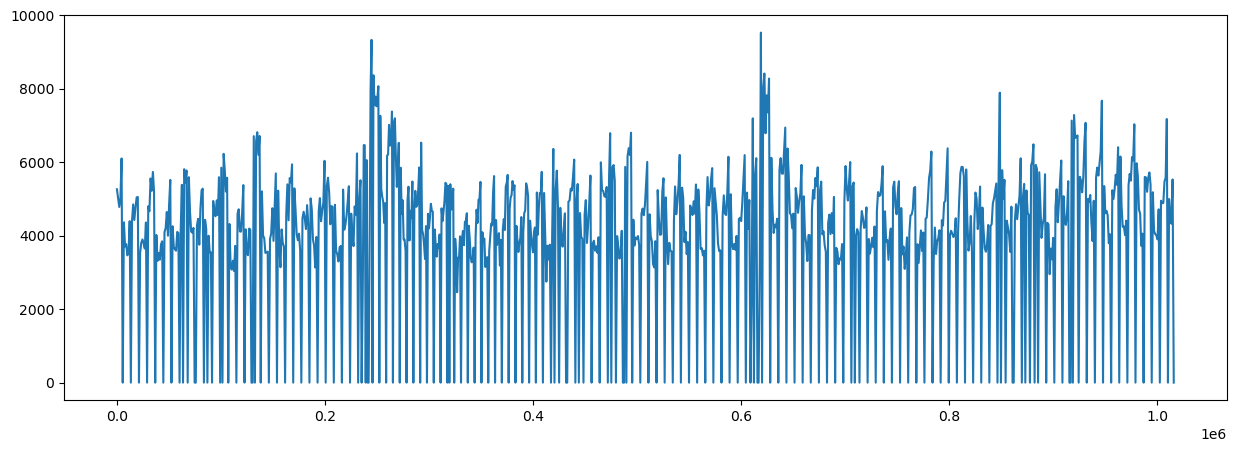

In [4]:
df[df['Store'] == 1]['Sales'].plot(figsize=(15, 5));

**This time series is quite interesting, as it seems to have seevral seasonal components at different levels. Also, it does this weird thing where sales plummet to zero frequently, but these represent days when Store 1 is closed (Open=0).**

In [5]:
# How many days in data when Store 1 is not open? 161 days out of 942 days

(df[df['Store'] == 1]['Sales'] == 0).sum()

161

## Format input data for Prophet

**You need to filter the dataset to univariate time series, i.e. sales for Store 1.**

In [6]:
store1 = df[df['Store'] == 1].copy()

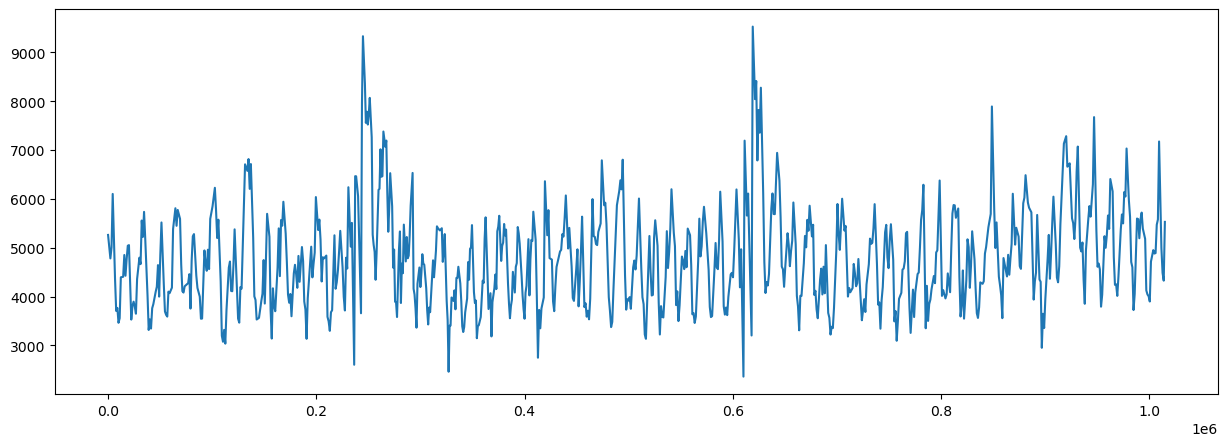

In [7]:
# Plot sales for days when store 1 is open

store1[store1['Open'] > 0]['Sales'].plot(figsize=(15, 5));

**This plot looks much more reasonable - you do not want to model the data when the store is closed, because there are no sales.**

In [8]:
# Compare dates when sales are zero with dates when store is closed

sales0 = store1[store1['Sales'] == 0].index

customers0 = store1[store1['Customers'] == 0].index

store_closed = store1[store1['Open'] == 0].index

print("Dates with zero sales equals Dates with zero customers:", np.all(sales0 == customers0))
print("Dates when store is closed equals Dates with zero customers:", np.all(store_closed == customers0))

Dates with zero sales equals Dates with zero customers: True
Dates when store is closed equals Dates with zero customers: True


In [9]:
store1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [10]:
# Format Date col and set as index

store1['Date'] = pd.to_datetime(store1['Date'])

In [11]:
store1.set_index('Date', inplace=True)

In [12]:
store1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


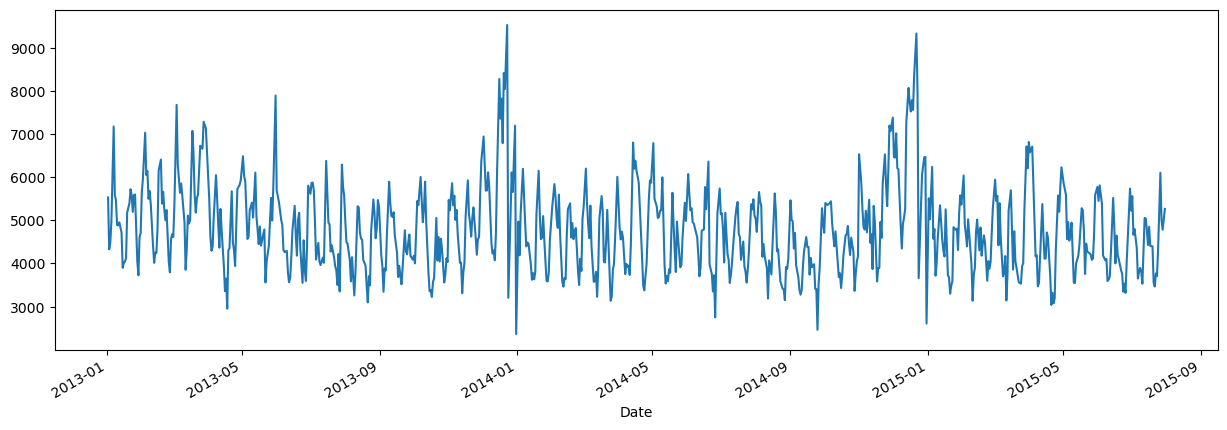

In [13]:
# Plot store sales when there are customers 

store1[store1['Customers'] > 0]['Sales'].plot(figsize=(15, 5));

In [14]:
# Include days when store is closed

df_p = store1[['Sales']].copy()

In [15]:
# Add ds column

df_p['Date'] = df_p.index

In [16]:
# NOTE: Dates are not in order

df_p.head()

,Sales,Date
Date,,
2015-07-31,5263,2015-07-31
2015-07-30,5020,2015-07-30
2015-07-29,4782,2015-07-29
2015-07-28,5011,2015-07-28
2015-07-27,6102,2015-07-27


In [17]:
df_p.tail()

,Sales,Date
Date,,
2013-01-05,4997,2013-01-05
2013-01-04,4486,2013-01-04
2013-01-03,4327,2013-01-03
2013-01-02,5530,2013-01-02
2013-01-01,0,2013-01-01


In [18]:
df_p.sort_index(inplace=True)

In [19]:
# First sales value is zero, i.e. New Years day holiday
# Store is closed every Sunday

df_p.head(20)

,Sales,Date
Date,,
2013-01-01,0,2013-01-01
2013-01-02,5530,2013-01-02
2013-01-03,4327,2013-01-03
2013-01-04,4486,2013-01-04
2013-01-05,4997,2013-01-05
2013-01-06,0,2013-01-06
2013-01-07,7176,2013-01-07
2013-01-08,5580,2013-01-08
2013-01-09,5471,2013-01-09


In [20]:
df_p.tail()

,Sales,Date
Date,,
2015-07-27,6102,2015-07-27
2015-07-28,5011,2015-07-28
2015-07-29,4782,2015-07-29
2015-07-30,5020,2015-07-30
2015-07-31,5263,2015-07-31


In [21]:
# Rename columns

df_p.columns = ['y', 'ds']

In [22]:
df_p.head()

,y,ds
Date,,
2013-01-01,0,2013-01-01
2013-01-02,5530,2013-01-02
2013-01-03,4327,2013-01-03
2013-01-04,4486,2013-01-04
2013-01-05,4997,2013-01-05


## Build Prophet model

**For those not experienced in machine-learning, you can instantiate the model object without any parameters, so that Prophet handles everything automatically. If you need optimization there are some options:**

* **`growth` can be 'linear' or 'logistic'.**
* **`changepoints` allows you to explicitly specify change points with a list of timesteps.**
* **`n_changepoints` allows you to select the number of potential change points (when you have not specified them explicitly). The default value is 25.**
* **`changepoint_range` is the percentage of data where you want the change points to exist. This is set to 0.8 by default, which means that no change points will occur in the final 20% of the time series. This is because the model may overfit due to lack of data near the end.**
* **`yearly_seasonality` can be True, False or 'auto' telling Prophet to look at yearly seasonality. You can let Prophet assess automatically, or customize if results are strange.**
* **`weekly_seasonality` can be True, False or 'auto' telling Prophet to look at weekly seasonality. The easiest method is to let Prophet assess automatically, but you can customize if results need tuning.**
* **`daily_seasonality` can be True, Fallse or 'auto' telling Prophet to look at daily seasonality. Again, you can let Prophet assess automatically or customize yourself.**
* **`holidays` parameter allows you to pass in a specially formatted DataFrame of holiday dates, but careful because the formatting must be precise. Check the documentation.** 
* **`seasonality_mode` can be either 'additive' or 'multiplicative'.**
* **`seasonality_prior_scale` is set to 10 by default, and measures the number of priors in the seasonality component (Bayesian model).**
* **`holidays_prior_scale` is set to 10 by default, and measures the number of priors in the holidays component (Bayesian model).**
* **`changepoint_prior_scale` is set to 0.05 by default, and measures the number of priors assigned to change points (Bayesian model).**

**The last three parameters can be tuned to get more reasonable results.**

In [23]:
m = Prophet()

In [24]:
m.fit(df_p)

06:59:35 - cmdstanpy - INFO - Chain [1] start processing
06:59:35 - cmdstanpy - INFO - Chain [1] done processing


**Note that for data with daily frequency, the daily seasonality is turned off automatically, since daily seasonality can only be computed by finer-grained data, e.g. hourly.**

### Make predictions

**Generating predictions from Prophet model happens in two steps:**

* **Create forecast DataFrame of timesteps**
* **Fill it with predictions**

**This process generates the in-sample and out-sample predictions at the same time, and the final DataFrame of results contains more than predictions - it also contains confidence levels, trends, etc.**

In [25]:
# forecast horizon (1 year) and freq is 'D' by default, i.e. daily, which is what you want

future = m.make_future_dataframe(periods=365, freq='D')

In [26]:
# dates from start of time series to end of forecast horizon

future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [27]:
future.tail()

,ds
1302,2016-07-26
1303,2016-07-27
1304,2016-07-28
1305,2016-07-29
1306,2016-07-30


In [28]:
# Fill future df with predictions

forecast = m.predict(future)

In [29]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1302,2016-07-26,3724.598999,3099.355571,5911.450412,3701.188524,3747.159420,713.049649,713.049649,713.049649,706.388265,706.388265,706.388265,6.661384,6.661384,6.661384,0.0,0.0,0.0,4437.648648
1303,2016-07-27,3724.361238,2809.040973,5748.498962,3700.889825,3747.031621,502.189794,502.189794,502.189794,510.594230,510.594230,510.594230,-8.404436,-8.404436,-8.404436,0.0,0.0,0.0,4226.551032
1304,2016-07-28,3724.123477,2425.550802,5328.537104,3700.605885,3746.858561,126.204640,126.204640,126.204640,151.302734,151.302734,151.302734,-25.098094,-25.098094,-25.098094,0.0,0.0,0.0,3850.328117
1305,2016-07-29,3723.885716,2779.541727,5700.667174,3700.356025,3746.623080,530.572646,530.572646,530.572646,573.658633,573.658633,573.658633,-43.085987,-43.085987,-43.085987,0.0,0.0,0.0,4254.458361
1306,2016-07-30,3723.647954,3221.601750,5967.463003,3700.023393,3746.487424,937.120652,937.120652,937.120652,999.134741,999.134741,999.134741,-62.014089,-62.014089,-62.014089,0.0,0.0,0.0,4660.768606


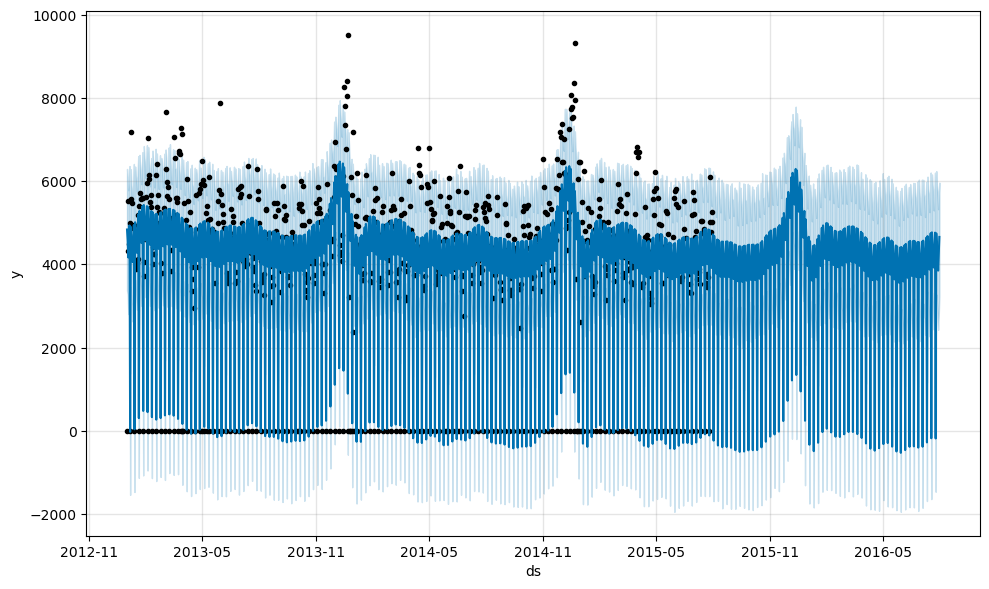

In [30]:
# Plot forecast

m.plot(forecast);

**The original data appears as the scattered black dots (the forecast period has no black dots) and the model predictions is the dark blue line, with the prediction intervals in the pale blue lines above and below.**

**Notice that the model is not able to assess that Sundays have zero sales when the store is not open, indicated by the thick black line along the x-axis at 0. This makes the predictions and confidence levels dip below zero, so human intervention is required by removing Sundays from the input data. See further down.**

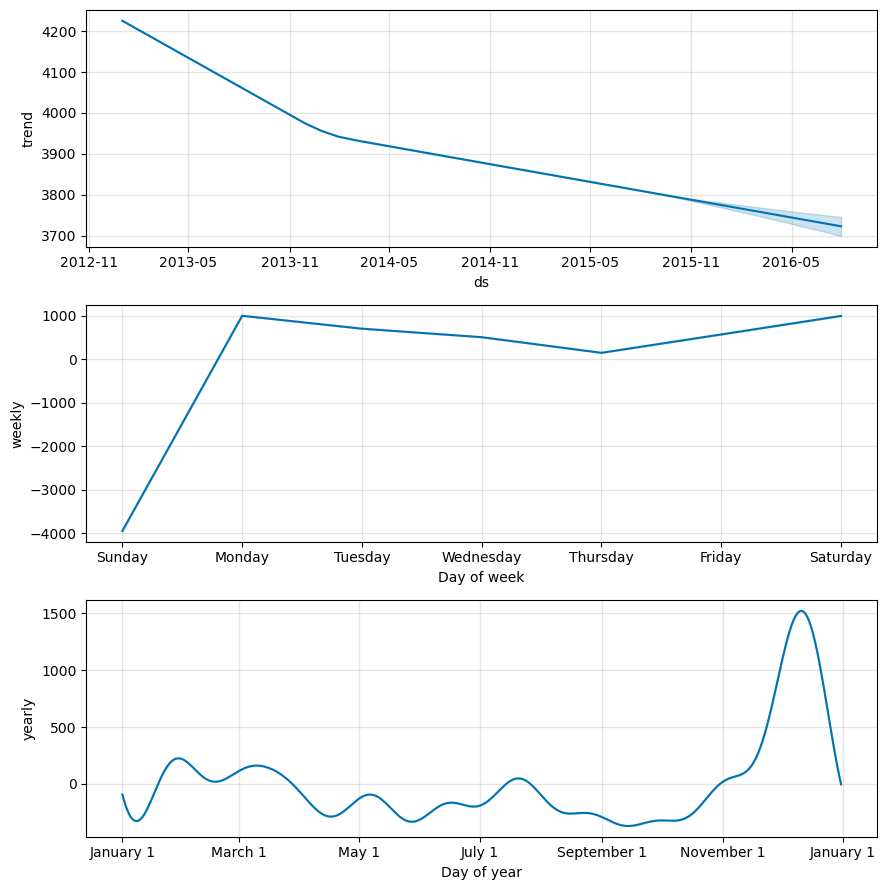

In [31]:
# Examine model components

m.plot_components(forecast);

**The function outputs the trend component, seasonal component and holiday component, if they exist.** 

**As you can see, the trend is decreasing over time, and note that there is one change point (approx 2014-02) at which the trend changes.**

**The weekly seasonality shows the impact of Sundays with a very negative value, which makes sense seeing as there are no sales made on Sundays. The yearly seasonality has a large peak around Christmas.**

## Prophet Model for open days only

In [32]:
df_p2 = store1[store1['Open'] > 0][['Sales']].copy()

# Set dates as index
df_p2['Date'] = df_p2.index

In [33]:
df_p2.head()

,Sales,Date
Date,,
2015-07-31,5263,2015-07-31
2015-07-30,5020,2015-07-30
2015-07-29,4782,2015-07-29
2015-07-28,5011,2015-07-28
2015-07-27,6102,2015-07-27


In [34]:
# Rename columns

df_p2.columns = ['y', 'ds']

07:06:19 - cmdstanpy - INFO - Chain [1] start processing
07:06:20 - cmdstanpy - INFO - Chain [1] done processing


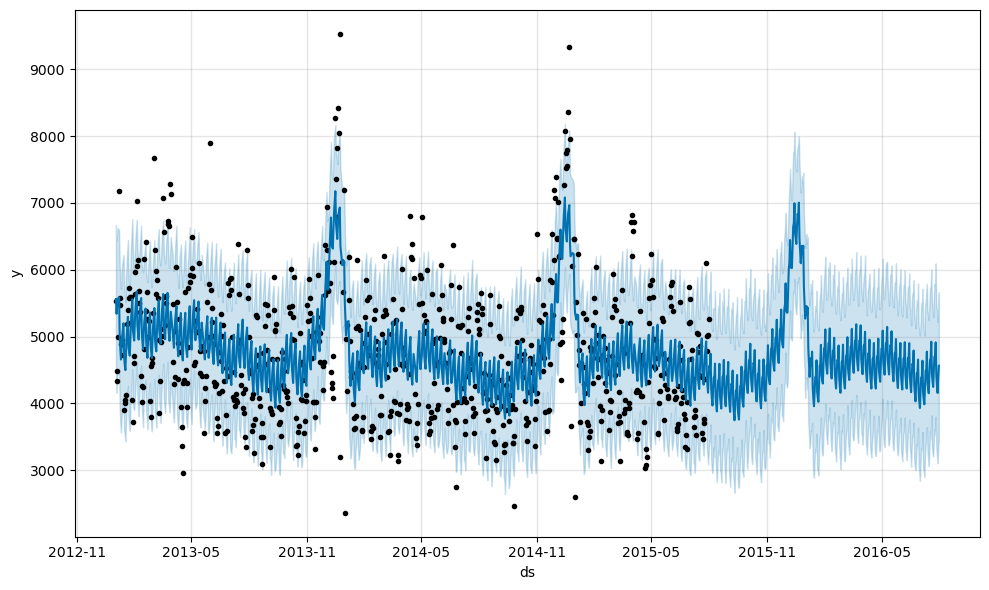

In [35]:
# Build model

m2 = Prophet()

m2.fit(df_p2)

# Forecast with model

future2 = m2.make_future_dataframe(periods=365)

forecast2 = m2.predict(future2)

m2.plot(forecast2);

**This now makes more sense and the prediction interval is much tighter - no longer going into negative values.**

**However, the model is still predicting values for Sundays since it is a continuous model, but those values are not valid seeing as the store is not open. As an analyst, you know that you will have to ignore them.**

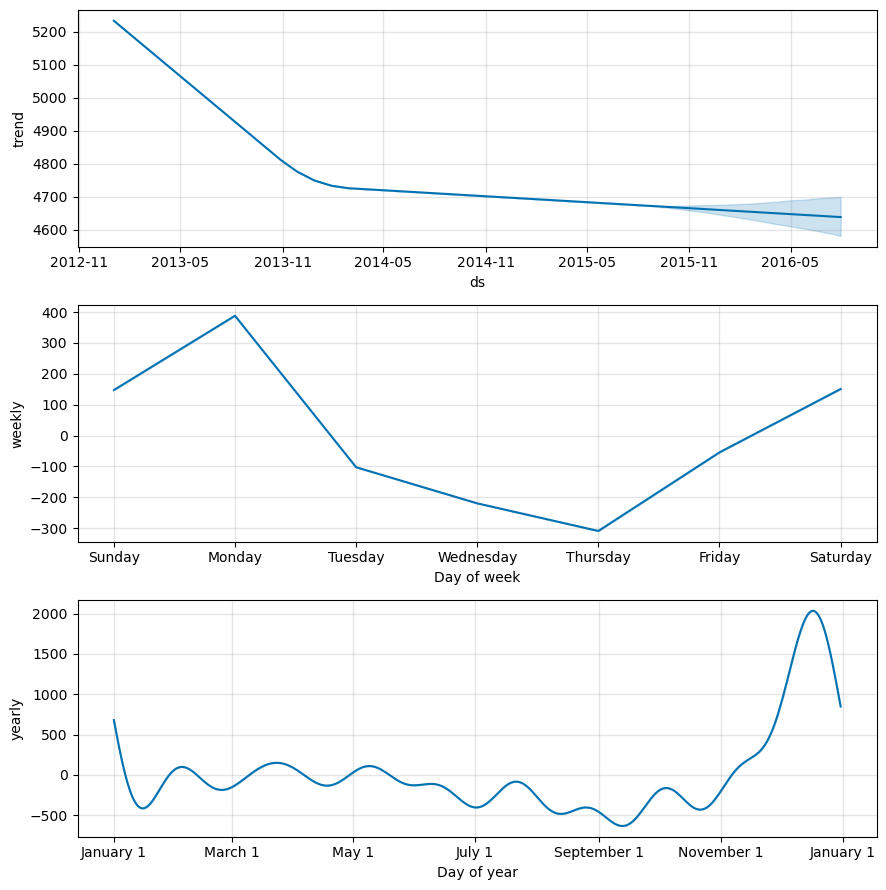

In [36]:
m2.plot_components(forecast2);

**The trend now decreases faster initially then gradually after the change point.**

**The weekly seasonality now looks very different than before, with sales dipping quickly till Thursday then increasing on the weekend. The influence of Sunday is no longer very negative, so you can see the model is interpolating.**

**The yearly seasonality has the same pattern as before with a higher peak around Christmas.**

## Prophet Model with added country-specific Holidays

**You don't know which country this dataset covers so have to make it up, but choose a European country to pass in function to add in built-in collection, e.g. 'FR' for France. The list of available country holidays can be found here https://github.com/vacanza/python-holidays/.**

In [37]:
m3 = Prophet()

In [38]:
m3.add_country_holidays(country_name='FR')

In [39]:
# Use data with open days only

m3.fit(df_p2)

07:23:55 - cmdstanpy - INFO - Chain [1] start processing
07:23:55 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future3 = m3.make_future_dataframe(periods=365)

In [41]:
forecast3 = m3.predict(future3)

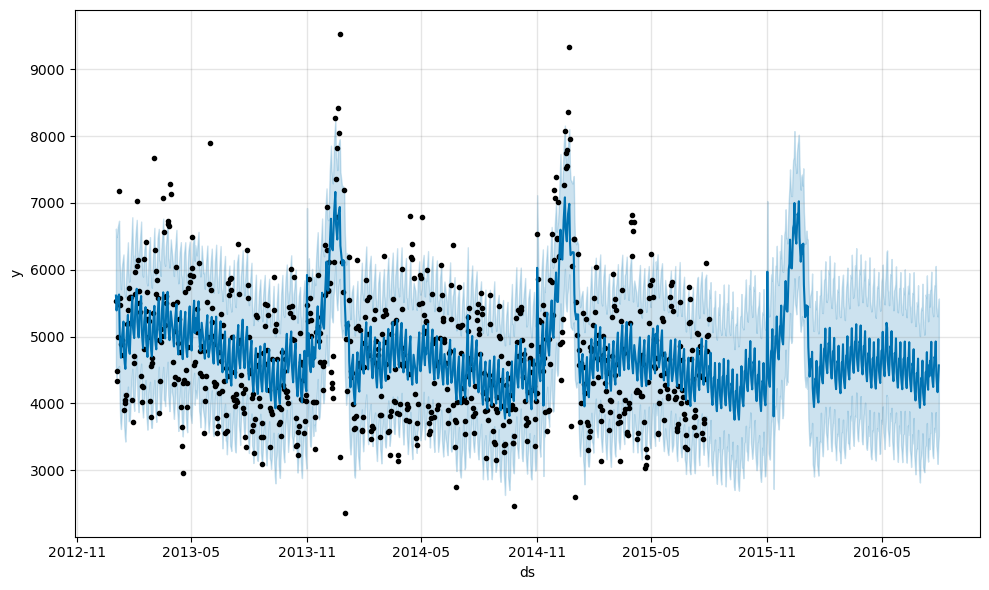

In [42]:
m3.plot(forecast3);

**The plot of predictions looks pretty similar to before, so it is not clear how well the model is doing.**

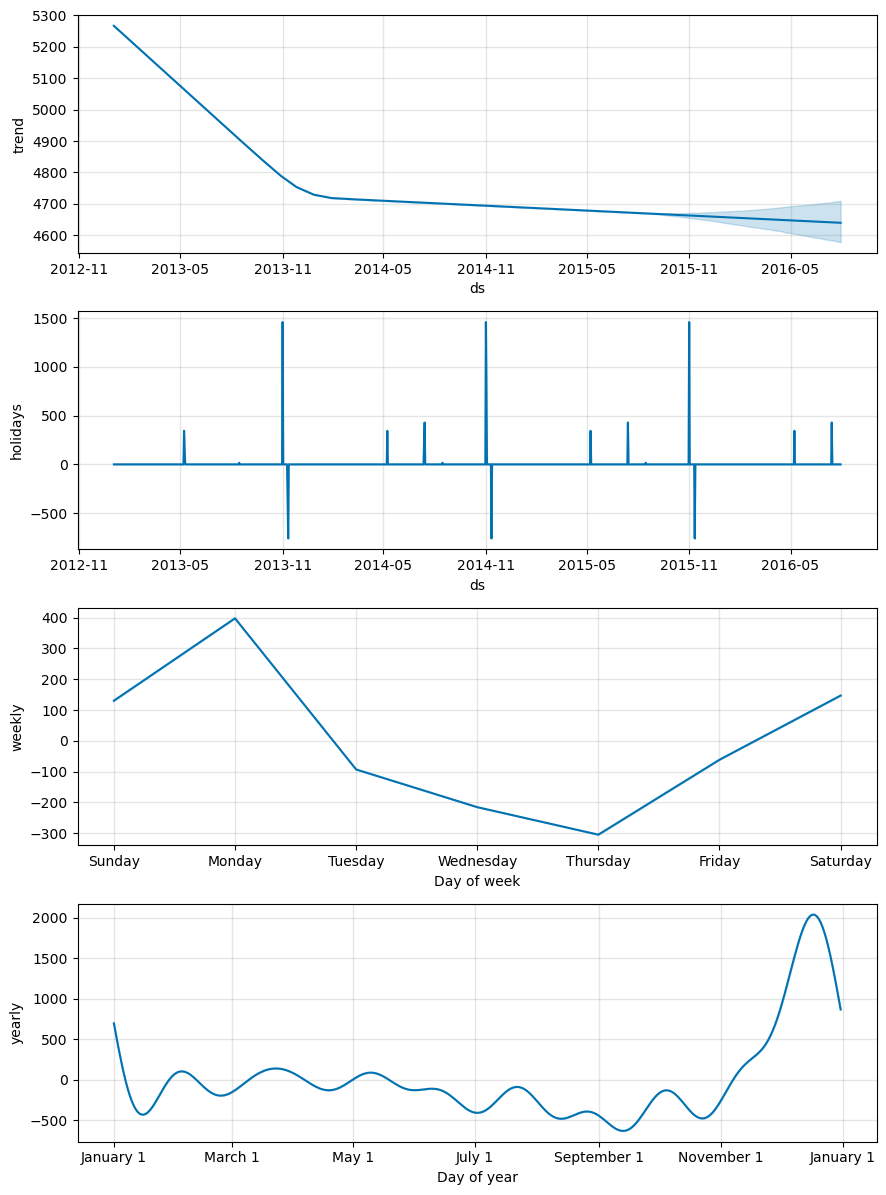

In [43]:
m3.plot_components(forecast3);

**There is new holidays component, which shows the influence of each French holiday. All the other plots look the same.**

## Prophet Model with added Regressors

**Exogenous Regressors refer to a more customized way to infer holidays, rather than calling a function with built-in dependency. Remember that the original dataset actually already contains the holidays for whatever country it represents, i.e. `StateHoliday` and `SchoolHoliday` columns. Essentially, you are adding exogenous input data in the form of DataFrame columns, to read as holidays.**

**Create sets of dates for Public holidays and School holidays, to ensure the uniqueness of the date values.**

In [44]:
set(store1['StateHoliday'])

{'0', 'a', 'b', 'c'}

**You need to check Kaggle data source, but national holiday values represent:**

    0 - No holiday
    a - Public holiday
    b - Easter holiday
    c - Christmas holiday

In [45]:
set(store1['SchoolHoliday'])

{0, 1}

**You need to check Kaggle data source, but the school holidays values represent:**

    0 - No school holiday
    1 - School holiday
    
**Add the columns from the original dataset to the model data that also represents days when the store is closed (columns `Open`, `Promo`, `StateHoliday` and `SchoolHoliday`).** 

In [46]:
df_p['open'] = store1['Open']

df_p['promo'] = store1['Promo']

# Dummy-code the values in State holidays seeing as some are letter (get 3 values as 4th is redundant)
df_p[['SH1', 'SH2', 'SH3']] = pd.get_dummies(store1['StateHoliday'], drop_first=True)

df_p['SchoolHoliday'] = store1['SchoolHoliday']

In [47]:
df_p.head(20)

,y,ds,open,promo,SH1,SH2,SH3,SchoolHoliday
Date,,,,,,,,
2013-01-01,0,2013-01-01,0,0,True,False,False,1
2013-01-02,5530,2013-01-02,1,0,False,False,False,1
2013-01-03,4327,2013-01-03,1,0,False,False,False,1
2013-01-04,4486,2013-01-04,1,0,False,False,False,1
2013-01-05,4997,2013-01-05,1,0,False,False,False,1
2013-01-06,0,2013-01-06,0,0,False,False,False,1
2013-01-07,7176,2013-01-07,1,1,False,False,False,1
2013-01-08,5580,2013-01-08,1,1,False,False,False,1
2013-01-09,5471,2013-01-09,1,1,False,False,False,1


In [48]:
help(Prophet.add_regressor)

Help on function add_regressor in module prophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: opti

In [49]:
# Build model and add each new regressor with name (required) and mode (defaults to seasonality)
# Regressors must be added before fitting the model

m4 = Prophet()

# i.e. when store is closed, multiply by zero to get zero
m4.add_regressor('open', mode='multiplicative')
m4.add_regressor('promo', mode='additive')
m4.add_regressor('SH1', mode='additive')
m4.add_regressor('SH2', mode='additive')
m4.add_regressor('SH3', mode='additive')
m4.add_regressor('SchoolHoliday', mode='additive')

m4.fit(df_p)

07:51:14 - cmdstanpy - INFO - Chain [1] start processing
07:51:15 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future4 = m4.make_future_dataframe(periods=365)

In [51]:
# Create train and test index as in-sample and out-sample predictions are in same dataset
# Check whether ds (date) value is in input data hence training set, otherwise test set

train_idx = future4['ds'].isin(df_p.index)

test_idx = ~train_idx

In [52]:
# Add regressors to forecast DataFrame (training set) - they are needed to make predictions

regressors = ['open', 'promo', 'SH1', 'SH2', 'SH3', 'SchoolHoliday']

for r in regressors:
    future4.loc[train_idx, r] = df_p[r].to_list()

In [53]:
# Difficult part is the test set...we do not have the true test target values
# Let's just pretend we know this, even though we do not - it takes a lot of work to gather this data

future4.loc[test_idx, 'open'] = future4.loc[test_idx, 'ds'].apply(lambda x: 1.0 * (x.weekday() != 6))

for r in regressors[1:]:
    future4.loc[test_idx, r] = df_p.iloc[-365:][r].to_list()

In [54]:
future4.tail(10)

,ds,open,promo,SH1,SH2,SH3,SchoolHoliday
1297,2016-07-21,1.0,0.0,False,False,False,0.0
1298,2016-07-22,1.0,0.0,False,False,False,0.0
1299,2016-07-23,1.0,0.0,False,False,False,0.0
1300,2016-07-24,0.0,0.0,False,False,False,0.0
1301,2016-07-25,1.0,0.0,False,False,False,0.0
1302,2016-07-26,1.0,1.0,False,False,False,1.0
1303,2016-07-27,1.0,1.0,False,False,False,1.0
1304,2016-07-28,1.0,1.0,False,False,False,1.0
1305,2016-07-29,1.0,1.0,False,False,False,1.0
1306,2016-07-30,1.0,1.0,False,False,False,1.0


In [55]:
# Fill forecast DataFrame with predictions

forecast4 = m4.predict(future4)

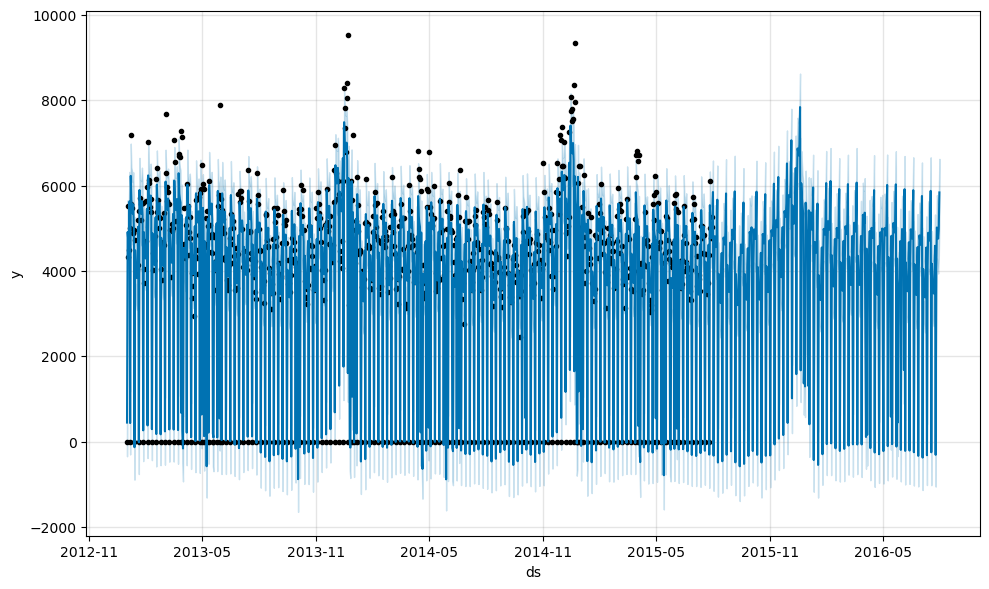

In [56]:
m4.plot(forecast4);

**Hmmm! Not what you expected! The model gives negative values, so it looks like it cannot handle the idea of zero sales when store is closed. It looks like removing closed days from the data was the best approach.**

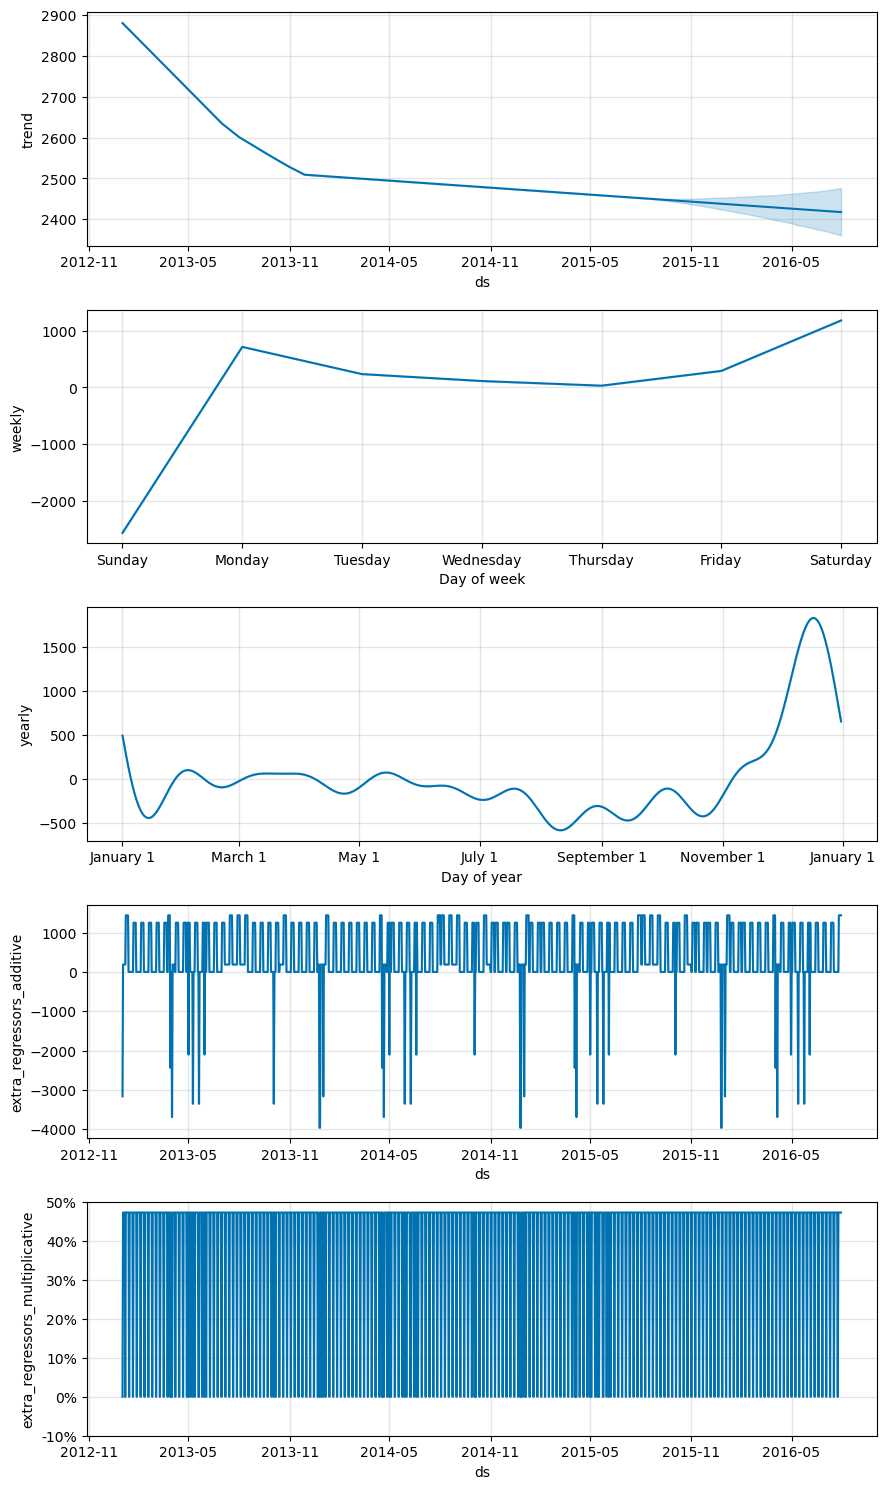

In [57]:
m4.plot_components(forecast4);

**Due to the added regressors, we now have new components for additive and multiplicative regressors...which don't tell us much!**

**The other components look the same, except the weekly seasonality has changed back to before when Sundays has a very negative impact.**


## Cross-Validation in Prophet

**Prophet built-in cross-validatation is very flexible and similar to the Walk-Forward technique. There are three parameters to customize:**

* **`initial` argument stands for the initial training period, and is set by default to three times the forecast horizon, i.e. 730 days (3 x 60).**
* **`period` argument is the size of the walk-forward step, and is set by default to half the forecast horizon, i.e. 30 days.**
* **`horizon` argument is the length of the forecast horizon, i.e. 60 days.**

**The cross-validation returns a DataFrame of results for ds (actual dates), yhat, yhat_lower, yhat_upper (confidence levels) and cutoff, which is a column of dates representing the date right before the first forecast, i.e. date from when the first forecast was made. The most important columns are the ds and yhat.**

**Performance metrics are also run within Prophet library, which returns a DataFrame of metrics like MAE, MSE, RMSE, MAPE etc. Performance metrics are computed on a moving average with rolling window size of 10% of the horizon, i.e. 6 timesteps. You can also plot the metrics in Prophet.**

In [58]:
from prophet.diagnostics import cross_validation

In [59]:
# -------------------------- Cross-validate data with closed days

df_cv = cross_validation(m, 
                         initial='730 days', 
                         period='30 days', 
                         horizon='60 days')

  0%|          | 0/6 [00:00<?, ?it/s]

08:04:33 - cmdstanpy - INFO - Chain [1] start processing
08:04:33 - cmdstanpy - INFO - Chain [1] done processing
08:04:34 - cmdstanpy - INFO - Chain [1] start processing
08:04:34 - cmdstanpy - INFO - Chain [1] done processing
08:04:34 - cmdstanpy - INFO - Chain [1] start processing
08:04:34 - cmdstanpy - INFO - Chain [1] done processing
08:04:35 - cmdstanpy - INFO - Chain [1] start processing
08:04:35 - cmdstanpy - INFO - Chain [1] done processing
08:04:35 - cmdstanpy - INFO - Chain [1] start processing
08:04:35 - cmdstanpy - INFO - Chain [1] done processing
08:04:36 - cmdstanpy - INFO - Chain [1] start processing
08:04:36 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-03,4612.183309,3155.979221,6107.998881,5023,2015-01-02
1,2015-01-04,-441.878139,-1963.557777,1050.456816,0,2015-01-02
2,2015-01-05,4574.131377,3174.287859,6024.945402,6239,2015-01-02
3,2015-01-06,4189.020494,2727.837552,5708.156553,4574,2015-01-02
4,2015-01-07,3950.876574,2559.593296,5454.719609,4796,2015-01-02
...,...,...,...,...,...,...
355,2015-07-27,4791.395410,3305.458836,6316.227103,6102,2015-06-01
356,2015-07-28,4466.849519,2971.154048,5917.429384,5011,2015-06-01
357,2015-07-29,4252.228830,2844.157212,5654.135710,4782,2015-06-01
358,2015-07-30,3876.622614,2423.869600,5273.623615,5020,2015-06-01


In [61]:
from prophet.diagnostics import performance_metrics

In [62]:
pm = performance_metrics(df_cv)

pm

,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days,2.223636e+06,1491.186110,919.609816,0.138169,0.550357,0.805556
1,7 days,1.587809e+06,1260.082987,758.556450,0.134227,0.491755,0.833333
2,8 days,1.462808e+06,1209.465833,705.495506,0.124071,0.486258,0.888889
3,9 days,1.165782e+06,1079.713909,689.723887,0.145229,0.453825,0.916667
4,10 days,5.043820e+05,710.198599,578.954183,0.156795,0.460461,0.944444
5,11 days,4.956430e+05,704.019148,570.084299,0.148970,0.403627,0.944444
6,12 days,8.562216e+05,925.322413,634.406011,0.148970,0.450544,0.944444
7,13 days,8.255995e+05,908.625081,605.628842,0.135744,0.441898,0.944444
8,14 days,7.805913e+05,883.510801,566.032339,0.123950,0.433057,0.944444
9,15 days,6.533861e+05,808.323022,496.764729,0.103078,0.414432,0.972222


**Note the horizon column contains the rolling days with window size of 10% of forecast horizon, i.e. starting 6 days from the cut-off date. Each rolling window contains the moving metric value, which you can plot by importing Prophet `plot_cross_validation_metric` function.**

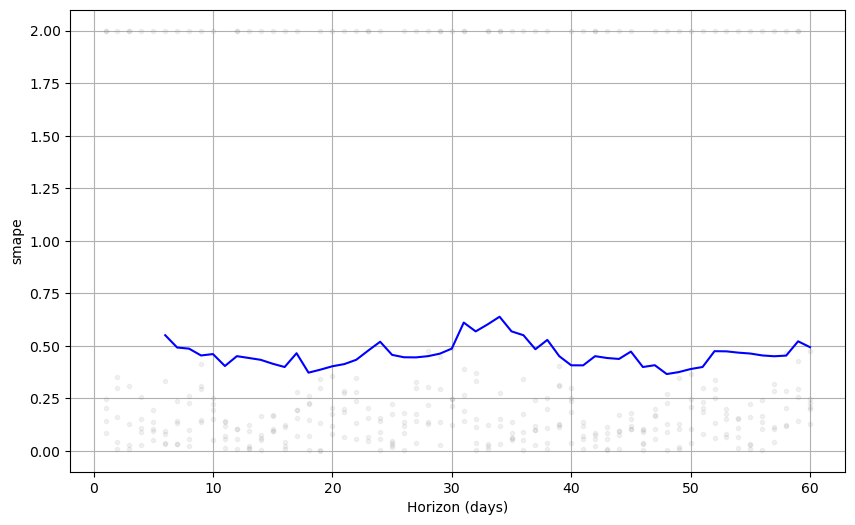

In [63]:
# SMAPE scores from 0 (perfect match) to 1 (no match at all)

from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='smape');

**The area looks pretty consistent around 50% over the forecast horizon (starting from 6th day).**

In [64]:
# ------------------------------------ Cross-validate data with open days only

df_cv2 = cross_validation(m2, 
                          initial='730 days', 
                          period='30 days', 
                          horizon='60 days')

  0%|          | 0/6 [00:00<?, ?it/s]

08:35:38 - cmdstanpy - INFO - Chain [1] start processing
08:35:38 - cmdstanpy - INFO - Chain [1] done processing
08:35:38 - cmdstanpy - INFO - Chain [1] start processing
08:35:38 - cmdstanpy - INFO - Chain [1] done processing
08:35:39 - cmdstanpy - INFO - Chain [1] start processing
08:35:39 - cmdstanpy - INFO - Chain [1] done processing
08:35:39 - cmdstanpy - INFO - Chain [1] start processing
08:35:39 - cmdstanpy - INFO - Chain [1] done processing
08:35:40 - cmdstanpy - INFO - Chain [1] start processing
08:35:40 - cmdstanpy - INFO - Chain [1] done processing
08:35:40 - cmdstanpy - INFO - Chain [1] start processing
08:35:40 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
pm2 = performance_metrics(df_cv2)

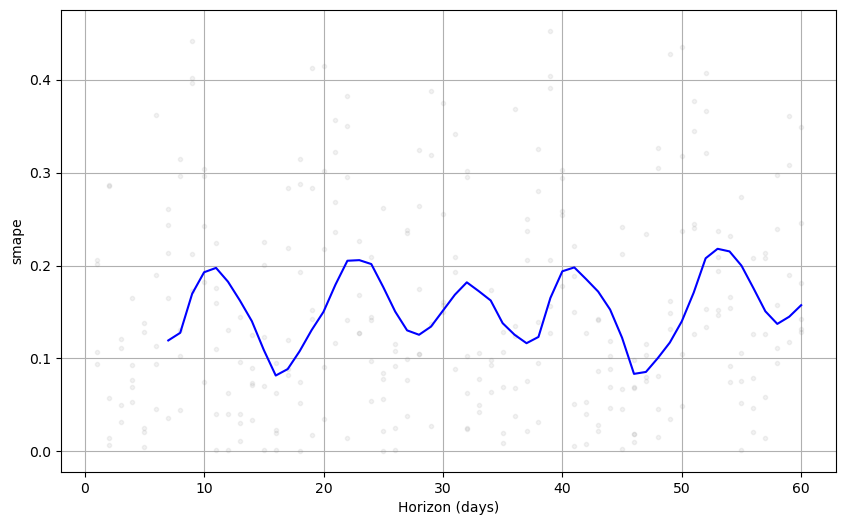

In [66]:
plot_cross_validation_metric(df_cv2, metric='smape');

**Interestingly, it has a cyclical pattern indicating rise and fall of SMAPE scores, but overall the scores are much lower indicating better performance.**

In [67]:
# ------------------------------------------ Cross-validate data with French national holidays

df_cv3 = cross_validation(m3, 
                          initial='730 days', 
                          period='30 days', 
                          horizon='60 days')

pm3 = performance_metrics(df_cv3)

  0%|          | 0/6 [00:00<?, ?it/s]

08:36:26 - cmdstanpy - INFO - Chain [1] start processing
08:36:27 - cmdstanpy - INFO - Chain [1] done processing
08:36:27 - cmdstanpy - INFO - Chain [1] start processing
08:36:27 - cmdstanpy - INFO - Chain [1] done processing
08:36:28 - cmdstanpy - INFO - Chain [1] start processing
08:36:28 - cmdstanpy - INFO - Chain [1] done processing
08:36:28 - cmdstanpy - INFO - Chain [1] start processing
08:36:28 - cmdstanpy - INFO - Chain [1] done processing
08:36:28 - cmdstanpy - INFO - Chain [1] start processing
08:36:28 - cmdstanpy - INFO - Chain [1] done processing
08:36:29 - cmdstanpy - INFO - Chain [1] start processing
08:36:29 - cmdstanpy - INFO - Chain [1] done processing


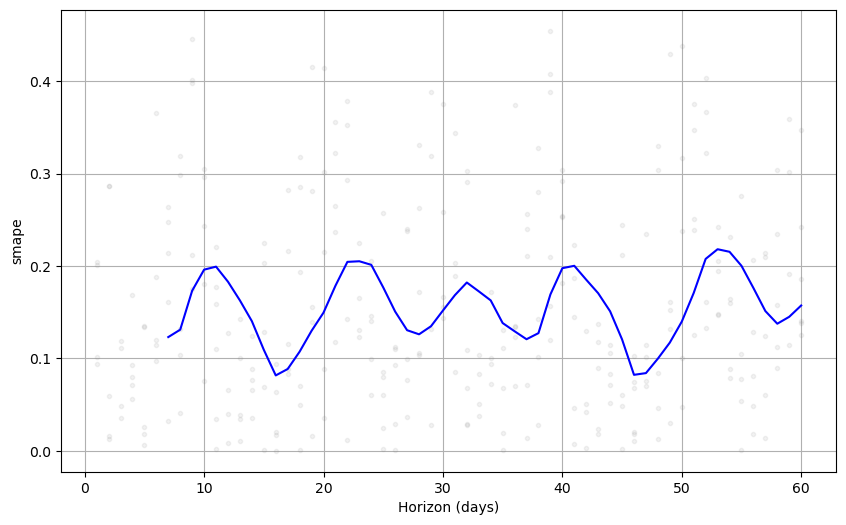

In [68]:
plot_cross_validation_metric(df_cv3, metric='smape');

**Again, we see this cyclical pattern at the same level, which means that French national holidays made no difference.**

In [69]:
# -------------------------------------- Cross-validate data with added regressors (customized holidays)

df_cv4 = cross_validation(m4, 
                          initial='730 days', 
                          period='30 days', 
                          horizon='60 days')

pm4 = performance_metrics(df_cv4)

  0%|          | 0/6 [00:00<?, ?it/s]

08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing


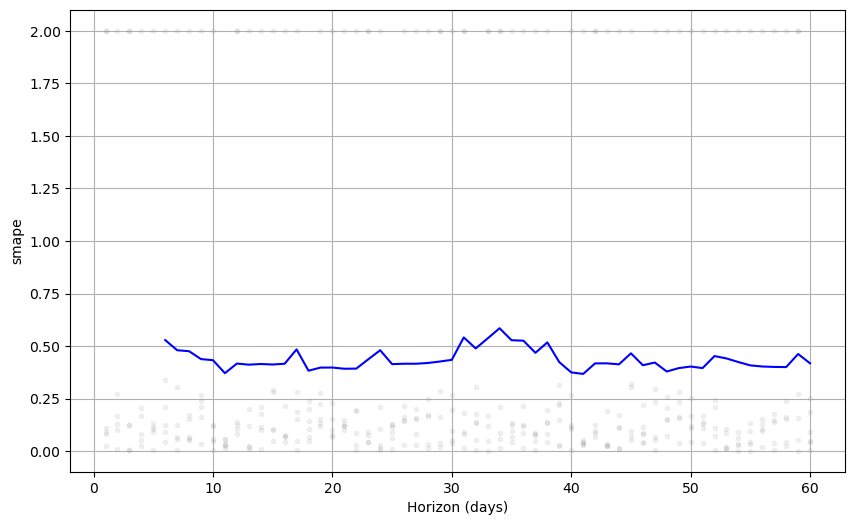

In [70]:
plot_cross_validation_metric(df_cv4, metric='smape');

**Back to the beginning again, where scores remain consistently around 50%. It looks like the model beneits most from removing closed store days from the model data.**

In [71]:
# Calculate mean SMAPE score for each model

print("Model with closed days:", pm['smape'].mean())
print("Model with open days only:", pm2['smape'].mean())
print("Model with French national holidays:", pm3['smape'].mean())
print("Model with customized holidays:", pm4['smape'].mean())

Model with closed days: 0.461775405515676
Model with open days only: 0.15371307521687194
Model with French national holidays: 0.15432067608194763
Model with customized holidays: 0.4357805114466114


**As expected, the best average SMAPE score is modeled with open days only, followed closely by the model with French national holidays (remember that you used data with open days only for French national holiday data so adding it did not help). The worst score is using the data as-is, i.e. with closed days included. Adding the exogenous regressors had a minimal effect.**

## Change Point Detection

**Change points refer to the points of change in a trend. They are already determined when calling the `fit()` method on the model, so you can already plot them along the trend line. Adding more change points only alters how they are visualized on the plot, to see whether the model has actually found something reasonable. Simply call Prophet's `add_changepoints_to_plot()` function with the plotted forecast.**

**NOTE: You can change the number of change points in the model when setting up the model object, with `n_changepoints` argument. You can also change the portion of data that the change points cover with `changepoint_range` argument, e.g. 0.9.**

In [72]:
from prophet.plot import add_changepoints_to_plot

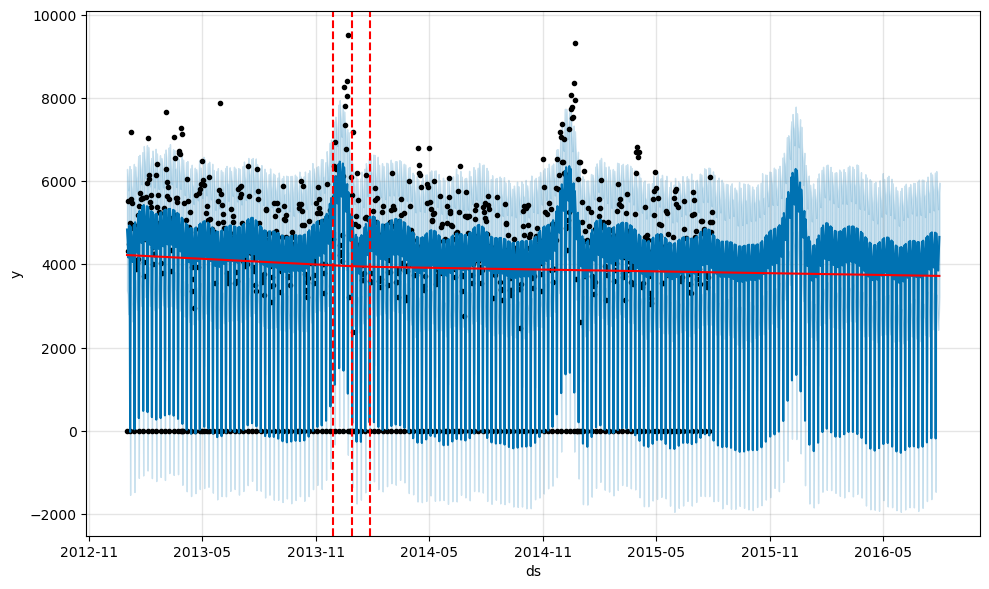

In [73]:
# Create plot object of forecasts for model with closed days included
fig = m.plot(forecast)

# Get current axes of plot and add model and forecast (per Prophet instructions)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

**You can now see the trend line with three change point detections, as the trend line becomes less steep. If you recall from plotting the trend component in the model with closed days included, there was only one change point detected.** 

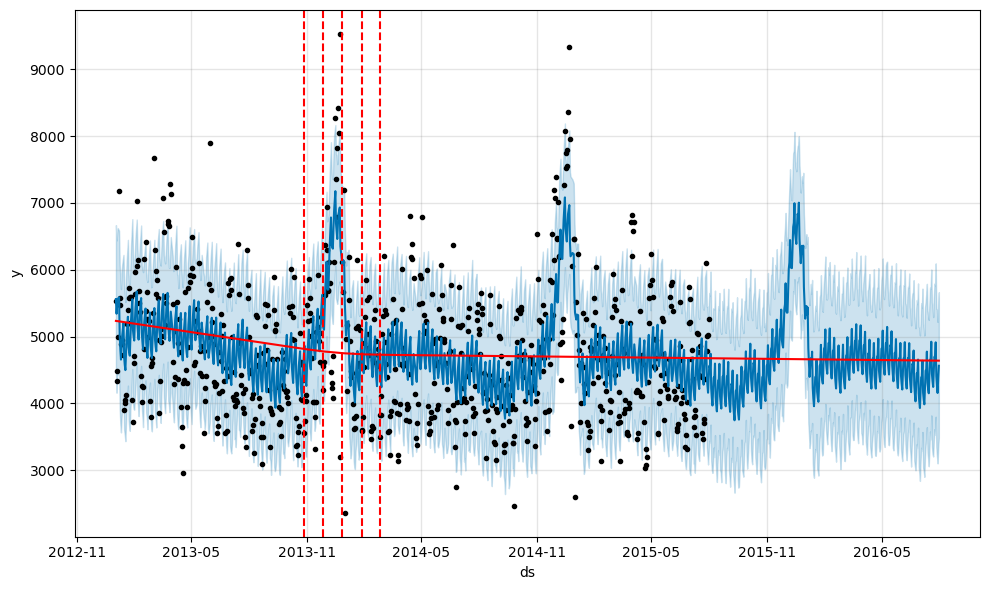

In [74]:
# Add change point to data with open days only

fig = m2.plot(forecast2)

a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

**Now we have five change points, showing greater sensitivity towards changes in the trend line. Remember that by default the model specifies 25 potential change points in the first 80% of the training data, and these are evenly-spaced apart.**

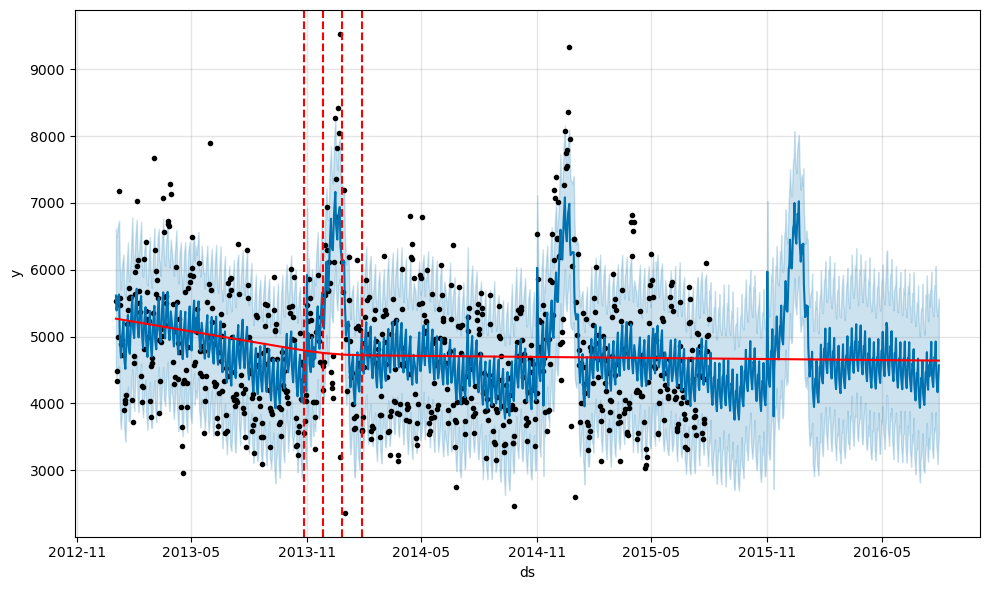

In [75]:
# Add change point to data with French holidays

fig = m3.plot(forecast3)

a = add_changepoints_to_plot(fig.gca(), m3, forecast3)

**Similar results but not as many change points. This was expected seeing as it scored closest to the open-days-only model.**

**If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse priors using the model function argument `changepoint_prior_scale` (by default set to 0.05). Increasing it will make the trend more flexible.**

**Lets see what happens when you tune the change point priors during model building**

09:13:17 - cmdstanpy - INFO - Chain [1] start processing
09:13:18 - cmdstanpy - INFO - Chain [1] done processing


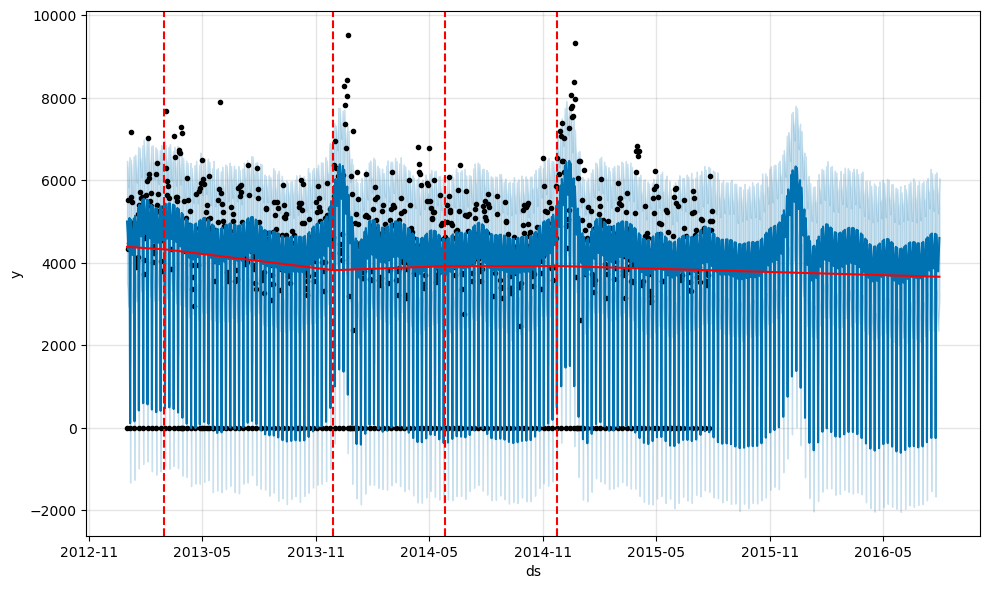

In [76]:
# Model with closed days included and increase priors to 0.5

m_a = Prophet(changepoint_prior_scale=0.5)

forecast_a = m_a.fit(df_p).predict(future)

fig = m_a.plot(forecast_a)

a = add_changepoints_to_plot(fig.gca(), m_a, forecast_a)

**With increased priors, the model with closed days has more change point detections showing greater flexibility.**

09:13:25 - cmdstanpy - INFO - Chain [1] start processing
09:13:26 - cmdstanpy - INFO - Chain [1] done processing


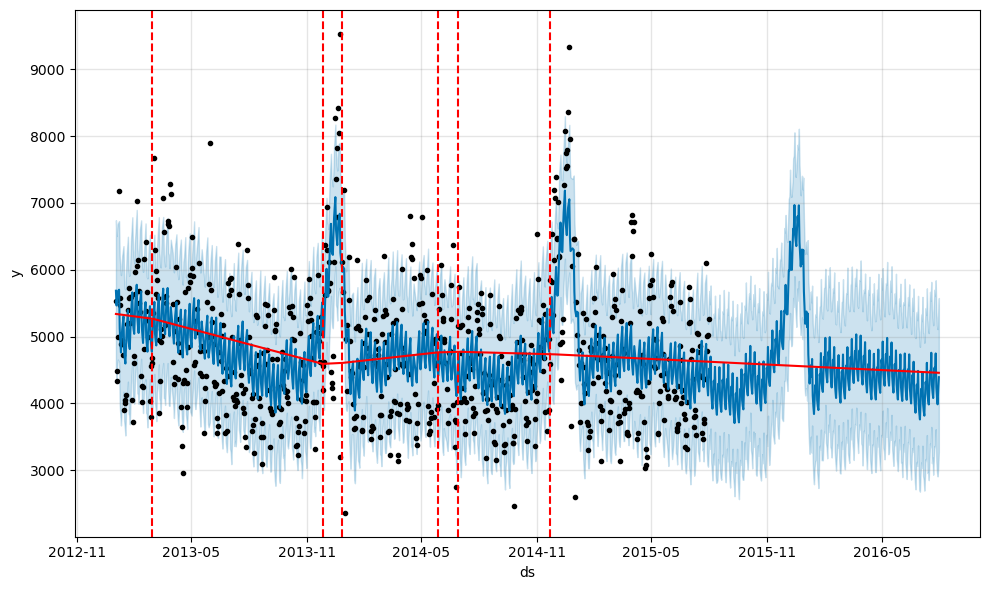

In [77]:
# Model with open days only and increase priors to 0.5

m2_a = Prophet(changepoint_prior_scale=0.5)

forecast2_a = m2_a.fit(df_p2).predict(future2)

fig = m2_a.plot(forecast2_a)

a = add_changepoints_to_plot(fig.gca(), m2_a, forecast2_a)

**With increased priors, there are more change points that reflect the changes in trend line better, rather than evenly-spaced lines. You could consider this a cleaner signal.**

09:13:32 - cmdstanpy - INFO - Chain [1] start processing
09:13:32 - cmdstanpy - INFO - Chain [1] done processing


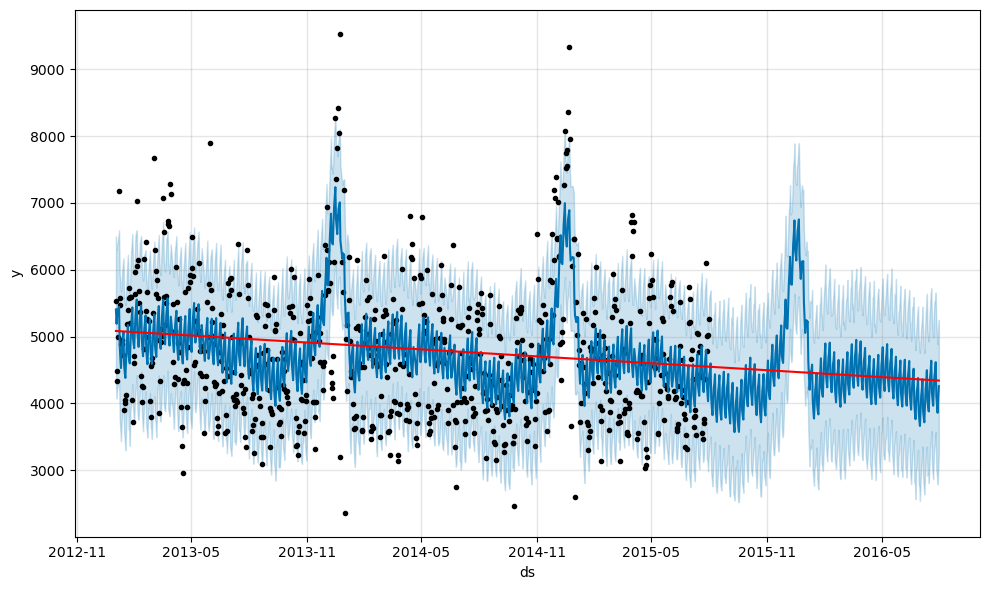

In [78]:
# Decrease priors to 0.005 for model with open days only

m2_a = Prophet(changepoint_prior_scale=0.005)

forecast2_a = m2_a.fit(df_p2).predict(future2)

fig = m2_a.plot(forecast2_a)

a = add_changepoints_to_plot(fig.gca(), m2_a, forecast2_a)

**With decreased priors, the trend line levels out and no change points are detected showing little flexibility.**